In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from torch_geometric.data import Data
import random
import json

In [2]:
data = pd.read_csv('data/ALLFLOWMETER_HIKARI2022.csv', index_col=0)

In [190]:
data.head()

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,attack_category,Label
0,Cmu9v81jToQyRF1gbk,184.0.48.168,38164,184.0.48.150,50443,0 days 00:00:00.000060,1,1,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
1,CO21hl3TWkuXTOgajk,184.0.48.169,43068,184.0.48.150,50443,0 days 00:00:00.000083,1,1,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
2,CBLJ6L19FP0MfYX7Oh,184.0.48.124,5678,255.255.255.255,5678,0 days 00:01:59.996602,3,0,3,0,...,5.999912e+07,1.199966e+08,5.999830e+07,1156.846698,0,0,0,0,Benign,0
3,ChTG451zJ7hUYOcqje,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.996909,2,0,2,0,...,5.999691e+07,5.999691e+07,5.999691e+07,0.000000,0,0,0,0,Benign,0
4,Cn9y6E2KVxzQbs5wjc,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.992130,2,0,2,0,...,5.999213e+07,5.999213e+07,5.999213e+07,0.000000,0,0,0,0,Benign,0


In [290]:
# random drop off edges because it's so dense?

In [3]:
with open('configs/sampler_config.json', 'r') as f:
        config = json.load(f)
        f.close()

In [4]:
IN_FILES = config['in_file_paths']
OUT_FILE = config['out_file_path']
NUM_SAMPLE = config['num_of_samples']
REAL_ALPHA = config['real_data_alpha']
NUM_REAL = int(NUM_SAMPLE * REAL_ALPHA)
NUM_BA = NUM_SAMPLE - NUM_REAL

In [203]:
dfs = []
for file in IN_FILES:
    df = pd.read_csv(file, index_col=0)
    if 'traffic_category' in df.columns:
        df = df.rename(columns={"traffic_category": "attack_category"})
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

In [209]:
data.head()

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,attack_category,Label,bwd_last_window_size
0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1,NaN
1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,...,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1,NaN
2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,...,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1,NaN
3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,...,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1,NaN
4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,...,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1,NaN


In [210]:
data.columns[data.isnull().any()]

Index(['bwd_last_window_size'], dtype='object')

In [5]:
unique_originh = list(set(data['originh']))
unique_responh = list(set(data['responh']))
unique_all = list(set(unique_originh + unique_responh))

In [212]:
node_ip_to_id = {}
for i, ip in enumerate(unique_all):
    node_ip_to_id[ip] = i


In [7]:
# sources = [node_ip_to_id[x] for x in data['originh'].values]
# targets = [node_ip_to_id[x] for x in data['responh'].values]
# G.add_edges_from([(s, t) for s, t in zip(sources, targets)])

In [6]:
G = nx.Graph()

In [7]:
for i, row in tqdm(data.iterrows(), total=len(data)):
    G.add_edge(row['originh'], row['responh'])

100%|██████████| 228253/228253 [00:06<00:00, 35692.46it/s]


In [12]:
sample_node = np.random.choice(unique_originh, 1)[0]

In [13]:
hop = 4
cut_off = 20
nodes = [sample_node]
frontier = [sample_node]
visited = [sample_node]
for h in range(hop):
    new_frontier = []
    for f in frontier:
        neighbours = [x for x in list(G.adj[f]) if x not in visited]
        if len(neighbours) == 0:
            continue
        elif len(neighbours) > cut_off:
            neighbours = random.sample(neighbours, cut_off)
        print(neighbours)

        nodes += neighbours
        new_frontier += neighbours
        visited.append(f)
    frontier = new_frontier


['184.0.48.150']
['147.182.227.17', '89.248.165.132', '184.105.139.91', '178.62.140.102', '162.159.200.123', '104.131.158.169', '103.203.58.1', '192.241.222.206', '58.42.237.24', '18.190.7.94', '87.241.169.176', '138.197.181.62', '192.241.222.127', '39.106.56.72', '221.2.163.231', '58.57.182.34', '106.14.118.178', '192.241.224.227', '134.17.94.100', '141.98.10.174']


In [14]:
subgraph = G.subgraph(nodes)

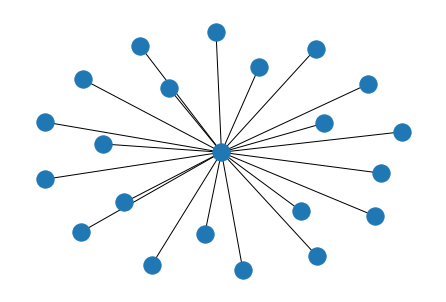

In [15]:
nx.draw(subgraph)

In [10]:
id_graph = nx.convert_node_labels_to_integers(subgraph)

In [153]:
with open('configs/recurrent_sampler_config.json', 'r') as f:
    rnn_config =  json.load(f)
    f.close()

In [63]:
dg = nx.DiGraph()
dg.add_edges_from(list(id_graph.edges))

In [65]:
nx.to_numpy_array(dg).astype(int)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0,

In [66]:
adj_mat = nx.to_numpy_array(dg)
adj_mat

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [67]:
len(adj_mat)

22

In [161]:
def create_dynamic_networks(adj_mat, drop_prob, add_prob, t):
    if t == 0:
        return []
    else:
        nnode = len(adj_mat)
        drop_edges = np.floor(np.random.rand(nnode,nnode) / (1-drop_prob))
        new_adj = ((adj_mat - drop_edges) > 0).astype(int)
        add_edges = np.floor(np.random.rand(nnode,nnode) / (1-add_prob))
        new_adj = ((new_adj + add_edges) > 0).astype(int)
        return [new_adj] + create_dynamic_networks(new_adj, drop_prob, add_prob, t-1)

def assign_clusters(number_of_types, size):
    return np.random.randint(0, number_of_types, size=size)  

def assign_labels(clusters, attack_combinations):
    nnode = clusters.shape[1]
    labels = []
    for t, cls_t in enumerate(clusters):
        history = clusters[:t+1, :, :]
        history = np.transpose(history, axes=(1,2,0))
        
        labels_t = np.zeros((nnode, nnode))
        for atk in attack_combinations:
            if len(atk) > history.shape[-1]:
                continue
            
            repeated_perm = np.tile(atk, [nnode, nnode]).reshape(nnode, nnode, -1)
            labels_t += (history[:,:,-len(atk):]==repeated_perm).all(axis=2).astype(int)
        labels_t[cls_t == -1] = -1
        labels.append(labels_t)
    
    return np.stack(labels)

dynamic_networks = np.stack(create_dynamic_networks(adj_mat, 0.1, 0.05, 5))
clusters = []
for g_t in dynamic_networks:
    clusters.append(np.select([g_t == 0, g_t !=0], [-1, assign_clusters(4, size=(len(g_t),len(g_t)))]))

clusters = np.stack(clusters)

labels = assign_labels(clusters, rnn_config['attack_combinations'])

In [135]:
history = np.transpose(clusters, axes=(1,2,0))

In [159]:
perm = [1,2]
repeated_perm = np.tile(perm, [22,22]).reshape(22,22,-1)
a = np.ones((22,22))
a[(history[:,:,-2:]==repeated_perm).all(axis=2)]=100
a

array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1., 100.,
          1.,   1.,   1.,   1., 

In [200]:
np.unique(data['attack_category'].values)

array(['Background', 'Benign', 'Bruteforce', 'Bruteforce-XML', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

In [202]:
categorial_to_id = {
    'Benign': 0,
    'Background': 0,
    'Bruteforce': 1,
    'Bruteforce-XML': 2,
    'Probing': 3,
    'XMRIGCC CryptoMiner': 4
}

In [179]:

data['flow_duration'] = data['flow_duration'].apply(lambda x: flow_duration_to_float(x))
benign_df = data[data['attack_category']=='Benign']
bf_df = data[data['attack_category']=='Bruteforce']
bfxml_df = data[data['attack_category']=='Bruteforce-XML']
crypto_df = data[data['attack_category']=='XMRIGCC CryptoMiner']
malicious_df = data[data['attack_category']!='Benign']

In [31]:
len(subgraph.edges)

31

In [104]:
def sample_edge_attributes(num_of_edges, benign_df, malicious_df, pos_ratio, features):
    attributes = []
    for i in range(num_of_edges):
        # sample from malicious
        if np.random.uniform(0,1) < pos_ratio:
            sample = malicious_df.sample(1)
            feature_values = sample[features].to_dict('records')[0]
            # add label
            feature_values['label'] = categorial_to_id[sample['attack_category'].values[0]]
            attributes.append(feature_values)
        else:
            sample = benign_df.sample(1)
            feature_values = sample[features].to_dict('records')[0]
            # add label
            feature_values['label'] = categorial_to_id[sample['attack_category'].values[0]]
            attributes.append(feature_values)
    return attributes

In [182]:
edge_attrs = sample_edge_attributes(len(subgraph.edges), benign_df, malicious_df, config['force_pos_lable_ratio'], config['features'])
edge_features = {}
for i, k in enumerate(subgraph.edges):
    edge_features[k] = edge_attrs[i]

In [183]:
nx.set_edge_attributes(subgraph, values=edge_features)

In [185]:
with open('single_sample.json', 'w') as f:
    f.write(json.dumps(nx.to_dict_of_dicts(subgraph)))
    f.close()

In [112]:
edge_features

{('193.163.125.231', '184.0.48.150'): {'flow_duration': 3.9e-05,
  'fwd_pkts_tot': 1,
  'bwd_pkts_tot': 1,
  'fwd_data_pkts_tot': 0,
  'bwd_data_pkts_tot': 0,
  'fwd_pkts_per_sec': 25575.02439,
  'bwd_pkts_per_sec': 25575.02439,
  'flow_pkts_per_sec': 51150.04878,
  'down_up_ratio': 1.0,
  'fwd_header_size_tot': 40,
  'fwd_header_size_min': 40,
  'fwd_header_size_max': 40,
  'bwd_header_size_tot': 20,
  'bwd_header_size_min': 20,
  'bwd_header_size_max': 20,
  'flow_FIN_flag_count': 0,
  'flow_SYN_flag_count': 1,
  'flow_RST_flag_count': 1,
  'fwd_PSH_flag_count': 0,
  'bwd_PSH_flag_count': 0,
  'flow_ACK_flag_count': 1,
  'fwd_URG_flag_count': 0,
  'bwd_URG_flag_count': 0,
  'flow_CWR_flag_count': 0,
  'flow_ECE_flag_count': 0,
  'fwd_pkts_payload.min': 0.0,
  'fwd_pkts_payload.max': 0.0,
  'fwd_pkts_payload.tot': 0.0,
  'fwd_pkts_payload.avg': 0.0,
  'fwd_pkts_payload.std': 0.0,
  'bwd_pkts_payload.min': 0.0,
  'bwd_pkts_payload.max': 0.0,
  'bwd_pkts_payload.tot': 0.0,
  'bwd_pkts_p

In [33]:
data.attack_category.value_counts()

Benign                 214904
XMRIGCC CryptoMiner      7595
Bruteforce-XML           3650
Bruteforce               2104
Name: attack_category, dtype: int64

In [44]:
temp_df[features].iloc[0]['flow_duration']

6.1e-05

In [17]:
def flow_duration_to_float(flow):
    days = float(flow.split('days', 1)[0].strip())
    hh = days * 24
    remain = flow.split('days', 1)[1]
    hh += float(remain.split(':', 1)[0].strip())
    mm = hh * 60
    remain = remain.split(':', 1)[1]
    mm += float(remain.split(':', 1)[0].strip())
    remain = remain.split(':', 1)[1]
    ss = mm * 60
    ss += float(remain)
    return ss

In [56]:
data['flow_duration'] = data['flow_duration'].apply(lambda x: flow_duration_to_float(x))

/tmp/ipykernel_390/182727174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_features['flow_duration'] = temp_features['flow_duration'].apply(lambda x: flow_duration_to_float(x))


In [449]:
ba_graph = nx.barabasi_albert_graph(20,2)
ba_graph2 = nx.barabasi_albert_graph(20,2)
# nx.draw(ba_graph)
nx.is_isomorphic(ba_graph, ba_graph2)

False

False